In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random

# importo los .py
import sys
sys.path.append("aux")
import transformaciones
import config

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_train.csv"

arch_min_max_prod_cust = "datasets/emp3_min_max_prod_cust.csv"
arch_mean_std_prod_cust = "datasets/emp3_mean_std_prod_cust.csv"
arch_no_transf_prod_cust = "datasets/emp3_no_transf_prod_cust.csv"

In [4]:
GLOBAL_PROD_CUST_IDS = pd.DataFrame() #aca solamente se define, se setea mas abajo

In [5]:
def leer_df_auxiliar_transf(tipo_transf):
    if tipo_transf=="normalizacion":
        return pd.read_csv(arch_min_max_prod_cust)
    elif tipo_transf=="estandarizacion":
        return pd.read_csv(arch_mean_std_prod_cust)
    else:
        return pd.read_csv(arch_no_transf_prod_cust)

In [6]:
############ DEFINO Vector Global de Productos #################
def actualizar_global_prod_custs(prod_cust_values, y_vector):
    # Ademas del id y los valores para "destransformar", se deja el tn original porque la destransformacion puede no ser
    # precisa para <productos,cliente> que no estaban en train
    GLOBAL_PROD_CUST_IDS = pd.DataFrame(data={"prod_cust":prod_cust_values, "tn_orig":np.array(y_vector)})
    GLOBAL_PROD_CUST_IDS = GLOBAL_PROD_CUST_IDS.merge(df_prod_cust_val1_val2,how="left",on="prod_cust")
    GLOBAL_PROD_CUST_IDS = GLOBAL_PROD_CUST_IDS.sort_values(by="prod_cust",ascending=True)
    
    return GLOBAL_PROD_CUST_IDS

In [7]:
def error_rate(y, y_pred):
    y_pred = np.array(y_pred)
    
    #Solamente destransformo la prediccion (para el y tomo el original de la columna tn_orig)
    df_calculo = GLOBAL_PROD_CUST_IDS.copy()
    df_calculo["y_pred"] = y_pred
    df_calculo["y_pred_destransformado"]=df_calculo.apply(lambda row: transformaciones.destransformar_valor(config.TIPO_TRANSF_PARAM,row["y_pred"],row["valor_1"],row["valor_2"]),axis=1)

    y = df_calculo.tn_orig
    y_pred = df_calculo.y_pred_destransformado
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(labels,preds)
    return 'ER', ret_val, False

In [8]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [9]:
def objective(trial):
    print("****************", config.OBJECTIVE_PARAM, "****************")
    
    lgb_params = {
        'objective': config.OBJECTIVE_PARAM,
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0,config.L1_UPPER_PARAM),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0,config.L2_UPPER_PARAM),
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': config.MAX_BIN_PARAM,
        'learning_rate': trial.suggest_uniform('learning_rate', config.LEARNING_RATE_LOWER_PARAM,config.LEARNING_RATE_UPPER_PARAM ),
        'num_leaves' : trial.suggest_int('num_leaves', config.NUM_LEAVES_LOWER_PARAM, config.NUM_LEAVES_UPPER_PARAM),
        'feature_fraction': trial.suggest_uniform('feature_fraction', config.FEATURE_FRACTION_LOWER_PARAM, config.FEATURE_FRACTION_UPPER_PARAM),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', config.MIN_DATA_IN_LEAF_LOWER_PARAM, config.MIN_DATA_IN_LEAF_UPPER_PARAM),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [10]:
##############################################

[I 2023-12-04 15:28:52,368] A new study created in memory with name: no-name-ed70fbe5-e054-4d9c-821b-f7239d41b2d1


<prod-cust> a validar: 108
<prod-cust> a testear: 120
<prod-cust> a validar: 108
<prod-cust> a testear: 120
Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808]
Periodos validar: [201810]
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810]
Periodos holdout: [201902]
X_train: (2160, 480)
y_train: (2160,)

X_validate: (108, 480)
y_validate: (108,)

X_train_all: (2376, 480)
y_train_all: (2376,)

X_holdout: (120, 480)
y_holdout: (120,)
**************** tweedie ****************
Training until validation scores don't improve for 266 rounds
[100]	valid_0's ER: 66.6
[200]	valid_0's ER: 66.6


[I 2023-12-04 15:28:53,687] Trial 0 finished with value: 61.03 and parameters: {'lambda_l1': 902.0707372788208, 'lambda_l2': 941.9465074344243, 'learning_rate': 0.023143242922156117, 'num_leaves': 139, 'feature_fraction': 0.7458636917101236, 'min_data_in_leaf': 5394}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 66 rounds


[I 2023-12-04 15:28:54,163] Trial 1 finished with value: 61.03 and parameters: {'lambda_l1': 543.5908567276052, 'lambda_l2': 896.2111320413635, 'learning_rate': 0.2985020373410019, 'num_leaves': 25, 'feature_fraction': 0.6063402907668883, 'min_data_in_leaf': 2472}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 95 rounds


[I 2023-12-04 15:28:54,840] Trial 2 finished with value: 61.03 and parameters: {'lambda_l1': 363.64287813256846, 'lambda_l2': 596.0446288785934, 'learning_rate': 0.11032246235613842, 'num_leaves': 572, 'feature_fraction': 0.9466543222855233, 'min_data_in_leaf': 6499}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 88 rounds


[I 2023-12-04 15:28:55,373] Trial 3 finished with value: 61.03 and parameters: {'lambda_l1': 942.0677615287807, 'lambda_l2': 602.8495114685978, 'learning_rate': 0.129413966418935, 'num_leaves': 30, 'feature_fraction': 0.7228382899321992, 'min_data_in_leaf': 2651}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 101 rounds


[I 2023-12-04 15:28:56,152] Trial 4 finished with value: 61.03 and parameters: {'lambda_l1': 706.6604728739251, 'lambda_l2': 531.8872768576966, 'learning_rate': 0.09671115650082585, 'num_leaves': 1004, 'feature_fraction': 0.5088128116923377, 'min_data_in_leaf': 6010}. Best is trial 0 with value: 61.03.


[100]	valid_0's ER: 66.6
Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 73 rounds


[I 2023-12-04 15:28:56,640] Trial 5 finished with value: 61.03 and parameters: {'lambda_l1': 706.6609164345424, 'lambda_l2': 695.5414953378996, 'learning_rate': 0.21040167591234743, 'num_leaves': 268, 'feature_fraction': 0.9134006072900556, 'min_data_in_leaf': 6561}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 374 rounds
[100]	valid_0's ER: 66.6
[200]	valid_0's ER: 66.6
[300]	valid_0's ER: 66.6


[I 2023-12-04 15:28:58,345] Trial 6 finished with value: 61.03 and parameters: {'lambda_l1': 780.1967997406115, 'lambda_l2': 614.8630420308152, 'learning_rate': 0.015389403969178202, 'num_leaves': 582, 'feature_fraction': 0.9150981572197903, 'min_data_in_leaf': 5277}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 68 rounds


[I 2023-12-04 15:28:58,851] Trial 7 finished with value: 61.03 and parameters: {'lambda_l1': 534.3354532132003, 'lambda_l2': 691.9962661254293, 'learning_rate': 0.27464183910571355, 'num_leaves': 785, 'feature_fraction': 0.9528041938992864, 'min_data_in_leaf': 2965}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 114 rounds


[I 2023-12-04 15:28:59,545] Trial 8 finished with value: 61.03 and parameters: {'lambda_l1': 923.1846130453102, 'lambda_l2': 868.9585979348014, 'learning_rate': 0.07695687473591682, 'num_leaves': 110, 'feature_fraction': 0.5948883955627219, 'min_data_in_leaf': 6184}. Best is trial 0 with value: 61.03.


[100]	valid_0's ER: 66.6
Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 122 rounds


[I 2023-12-04 15:29:00,251] Trial 9 finished with value: 61.03 and parameters: {'lambda_l1': 44.93792813674746, 'lambda_l2': 590.4496952439472, 'learning_rate': 0.06879525175644356, 'num_leaves': 211, 'feature_fraction': 0.2958796742117283, 'min_data_in_leaf': 6676}. Best is trial 0 with value: 61.03.


[100]	valid_0's ER: 66.6
Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 79 rounds


[I 2023-12-04 15:29:00,891] Trial 10 finished with value: 61.03 and parameters: {'lambda_l1': 952.7180211893319, 'lambda_l2': 293.2454525480633, 'learning_rate': 0.17149859047106653, 'num_leaves': 375, 'feature_fraction': 0.7604738074346474, 'min_data_in_leaf': 473}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 66 rounds


[I 2023-12-04 15:29:01,411] Trial 11 finished with value: 61.03 and parameters: {'lambda_l1': 474.2938646661377, 'lambda_l2': 964.9349908849487, 'learning_rate': 0.29636923218520145, 'num_leaves': 17, 'feature_fraction': 0.46522496579502337, 'min_data_in_leaf': 4173}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 71 rounds


[I 2023-12-04 15:29:02,000] Trial 12 finished with value: 61.03 and parameters: {'lambda_l1': 589.629864768277, 'lambda_l2': 991.5375318927782, 'learning_rate': 0.2275291001685722, 'num_leaves': 372, 'feature_fraction': 0.7204667183319894, 'min_data_in_leaf': 452}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 260 rounds
[100]	valid_0's ER: 66.6
[200]	valid_0's ER: 66.6


[I 2023-12-04 15:29:03,270] Trial 13 finished with value: 61.03 and parameters: {'lambda_l1': 329.8129143206178, 'lambda_l2': 818.4763333788508, 'learning_rate': 0.023761413370250294, 'num_leaves': 170, 'feature_fraction': 0.6061854710890465, 'min_data_in_leaf': 7767}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 80 rounds


[I 2023-12-04 15:29:03,829] Trial 14 finished with value: 61.03 and parameters: {'lambda_l1': 813.4936758064584, 'lambda_l2': 835.2557607527685, 'learning_rate': 0.16245209239727545, 'num_leaves': 366, 'feature_fraction': 0.805214211576117, 'min_data_in_leaf': 2209}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 71 rounds


[I 2023-12-04 15:29:04,401] Trial 15 finished with value: 61.03 and parameters: {'lambda_l1': 648.7179039781007, 'lambda_l2': 424.10468643718104, 'learning_rate': 0.2334687842867109, 'num_leaves': 722, 'feature_fraction': 0.6253637167203581, 'min_data_in_leaf': 4162}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 77 rounds


[I 2023-12-04 15:29:04,981] Trial 16 finished with value: 61.03 and parameters: {'lambda_l1': 821.3616568216148, 'lambda_l2': 993.67110812338, 'learning_rate': 0.18287610541163152, 'num_leaves': 268, 'feature_fraction': 0.4014842734770704, 'min_data_in_leaf': 1678}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 69 rounds


[I 2023-12-04 15:29:05,511] Trial 17 finished with value: 61.03 and parameters: {'lambda_l1': 995.9836371141251, 'lambda_l2': 23.00022190393622, 'learning_rate': 0.25913491077855416, 'num_leaves': 134, 'feature_fraction': 0.22827834089110088, 'min_data_in_leaf': 5090}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 85 rounds


[I 2023-12-04 15:29:06,091] Trial 18 finished with value: 61.03 and parameters: {'lambda_l1': 851.1683704261512, 'lambda_l2': 784.1930871678043, 'learning_rate': 0.14175044366810163, 'num_leaves': 448, 'feature_fraction': 0.8188028781849002, 'min_data_in_leaf': 3403}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
**************** tweedie ****************
Training until validation scores don't improve for 75 rounds


[I 2023-12-04 15:29:06,601] Trial 19 finished with value: 61.03 and parameters: {'lambda_l1': 708.3967976784629, 'lambda_l2': 892.5161903970845, 'learning_rate': 0.19441339528438617, 'num_leaves': 61, 'feature_fraction': 0.6553117307924059, 'min_data_in_leaf': 1472}. Best is trial 0 with value: 61.03.


Early stopping, best iteration is:
[1]	valid_0's ER: 66.6
Evaluated only: ER
# Experimentos: 20
Mejor experimento: {'lambda_l1': 902.0707372788208, 'lambda_l2': 941.9465074344243, 'learning_rate': 0.023143242922156117, 'num_leaves': 139, 'feature_fraction': 0.7458636917101236, 'min_data_in_leaf': 5394}


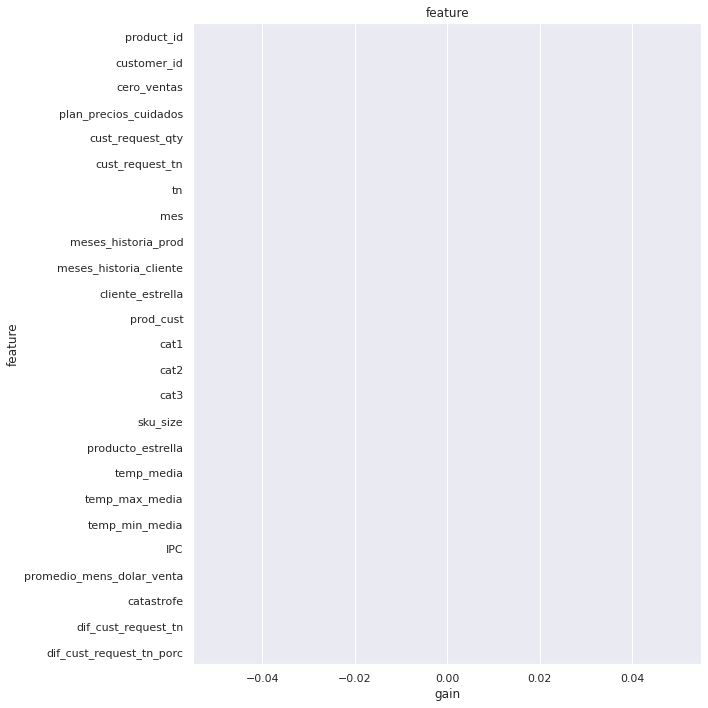

Error Holdout: 63.16


In [11]:
df_sellout = pd.read_csv(arch_entrada)

### Antes de transformar, se guardan los y_validate y holdout originales (se van a usar en el vector global)
# Esto se debe a que la "destransformacion" no siempre es perfecta, considerando productos que no estuvieron en train
df_sellout_validate_orig = df_sellout[df_sellout.periodo==config.VALIDATE_PERIODO_PARAM]
df_sellout_validate_orig = df_sellout_validate_orig.sort_values(by="prod_cust",ascending=True)
y_validate_orig = df_sellout_validate_orig.tn_mas_2_original
print("<prod-cust> a validar:", len(y_validate_orig))

df_sellout_holdout_orig = df_sellout[df_sellout.periodo==config.HOLDOUT_PERIODO_PARAM]
df_sellout_holdout_orig = df_sellout_holdout_orig.sort_values(by="prod_cust",ascending=True)
y_holdout_orig = df_sellout_holdout_orig.tn_mas_2_original
print("<prod-cust> a testear:", len(y_holdout_orig))

df_sellout = df_sellout.drop(columns=["tn_mas_2_original"])
df_prod_cust_val1_val2 = leer_df_auxiliar_transf(config.TIPO_TRANSF_PARAM)

### Categoricas
#Transformo todas las categoricas
categories = ["plan_precios_cuidados","cat1","cat2","cat3","product_id","customer_id","prod_cust","cero_ventas"]

for c in categories: 
    df_sellout[c] = df_sellout[c].astype("category")   
    
### Se descartan variables no utiles para la prediccion
df_sellout = df_sellout.drop(columns=["brand","periodo_fecha"])

### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_validate = df_sellout[df_sellout.periodo == config.VALIDATE_PERIODO_PARAM]

df_train_all = df_sellout[(df_sellout.periodo <= config.TRAIN_ALL_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_holdout = df_sellout[df_sellout.periodo == config.HOLDOUT_PERIODO_PARAM]

df_validate = df_validate.sort_values(by="prod_cust",ascending=True)
print("<prod-cust> a validar:", len(df_validate))

df_holdout = df_holdout.sort_values(by="prod_cust",ascending=True)
print("<prod-cust> a testear:", len(df_holdout))

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_validate.periodo.unique())
print("Periodos entrenar ALL:",df_train_all.periodo.unique())
print("Periodos holdout:",df_holdout.periodo.unique())

### Armado variables entrenamiento

cols_remover_entren = ["tn_mas_2","periodo"] #,"prod_cust","customer_id","product_id"
# Train - Validate
X_train = df_train.drop(columns=cols_remover_entren, axis=1)
X_validate = df_validate.drop(columns=cols_remover_entren, axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

# Train All - Holdout
X_train_all = df_train_all.drop(columns=cols_remover_entren, axis=1)
X_holdout = df_holdout.drop(columns=cols_remover_entren, axis=1)

y_train_all = df_train_all.tn_mas_2
y_holdout = df_holdout.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

print("\nX_train_all:", X_train_all.shape)
print("y_train_all:", y_train_all.shape)

print("\nX_holdout:", X_holdout.shape)
print("y_holdout:", y_holdout.shape)

cols = X_train.columns.tolist()

### Optimizacion Bayesiana
#Antes de entrenar, se setea vector global para validate
GLOBAL_PROD_CUST_IDS = actualizar_global_prod_custs(df_validate.prod_cust, y_validate_orig)

GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=config.CANT_ITERACIONES_OPT_BAY_PARAM)
print('# Experimentos:', len(study.trials))
print('Mejor experimento:', study.best_trial.params)

best_model_index = study.best_trial.number
best_model = GLOBAL_MODEL_ITER[best_model_index]
plot_lgb_importances(best_model, num=30, plot=True)

lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols)

final_params = GLOBAL_PARAMS_ITER[best_model_index]
final_best_iter = GLOBAL_BEST_IT_ITER[best_model_index]
final_model = lgb.train(final_params, lgbtrain_all, num_boost_round=final_best_iter)

GLOBAL_PROD_CUST_IDS = actualizar_global_prod_custs(df_holdout.prod_cust, y_holdout_orig)

y_pred_holdout = final_model.predict(X_holdout)
er_holdout = error_rate(y_holdout,y_pred_holdout)
print("Error Holdout:", er_holdout)

prediction_with_prod_cust = pd.DataFrame(data={"prod_cust":X_holdout.prod_cust,"actual_value":y_holdout_orig,"predicted_value":y_pred_holdout})